In [1]:
"""!pip install tiktoken
!pip install torch
!pip install tqdm
!pip install tensorflow"""

'!pip install tiktoken\n!pip install torch\n!pip install tqdm\n!pip install tensorflow'

In [2]:
from importlib.metadata import version

pkgs = [
    "matplotlib",  # Plotting library
    "tiktoken",    # Tokenizer
    "torch",       # Deep learning library
    "tqdm",        # Progress bar
    "tensorflow",  # For OpenAI's pretrained weights
]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.5.1
tiktoken version: 0.7.0
torch version: 1.12.1
tqdm version: 4.66.4
tensorflow version: 2.16.2


### LLM involves a training procedure where it learns to generate one word at a time. A pretrained LLM is good at text completion, but it is not good at following instructions. Lets tach LLM to follow instructions better

In [3]:
import os
import json
import urllib

def download_and_load_file(file_path):

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    with open(file_path, "r") as file:
        data = json.load(file)

    return data

file_path = "instruction-data.json"

data = download_and_load_file(file_path)
print("Number of entries:", len(data))

Number of entries: 1100


In [4]:
print("Example :\n", data[10])

Example :
 {'instruction': 'What is the contraction for "will not"?', 'input': '', 'output': 'The contraction for "will not" is "won\'t".'}


In [5]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n--------- Instruction ----------------------------------------\n{entry['instruction']} \n--------------------------------------------------------------"
    )

    input_text = f"\n\nInput: {entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [6]:
model_input = format_input(data[50])
desired_response = f"\n\nResponse: {data[50]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

--------- Instruction ----------------------------------------
Identify the correct spelling of the following word. 
--------------------------------------------------------------

Input: Ocassion

Response: The correct spelling is 'Occasion.'


In [7]:
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


In [8]:
import torch
from torch.utils.data import Dataset


class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

In [9]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


 To accelerate training, we collect multiple examples in a batch and pad all inputs to a uniform length. We use a custom "collate" function for the data loader to pad training examples in each batch to the same length, allowing different batches to have different lengths.

In [10]:
def custom_collate_draft_1(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # Determine the maximum sequence length in the batch, accounting for the added token
    max_length = max(len(sequence) + 1 for sequence in batch)

    # Initialize a list to hold padded sequences
    padded_sequences = []

    for sequence in batch:
        # Copy the sequence and append the padding token
        sequence_with_pad = sequence.copy()
        # Add an <|endoftext|> token
        sequence_with_pad.append(pad_token_id)

        # Pad the sequence to the maximum length which always adds at least 1 additional padding tokens
        padding = [pad_token_id] * (max_length - len(sequence_with_pad))
        padded_sequence = sequence_with_pad + padding

        # Remove the extra padding token and convert to a tensor
        sequence_tensor = torch.tensor(padded_sequence[:-1])
        padded_sequences.append(sequence_tensor)

    # Stack the tensors and move to the specified device
    batch_tensor = torch.stack(padded_sequences).to(device)
    return batch_tensor


In [11]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


We returned only the inputs for the LLM, but for training, we also need the target values. In LLM training, the targets are the inputs shifted by one position to the right, allowing the LLM to learn to predict the next token.

In [12]:
def custom_collate_draft_2(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # Determine the maximum sequence length in the batch, accounting for the added padding token
    max_length = max(len(sequence) + 1 for sequence in batch)

    # Initialize lists to hold padded inputs and targets
    padded_inputs, padded_targets = [], []

    for sequence in batch:
        # Copy the sequence and append the padding token
        sequence_with_pad = sequence.copy()
        sequence_with_pad.append(pad_token_id)

        # Pad the sequence to the maximum length which always adds at least 1 additional padding token
        padding = [pad_token_id] * (max_length - len(sequence_with_pad))
        padded_sequence = sequence_with_pad + padding

        # Create input and target tensors
        input_tensor = torch.tensor(padded_sequence[:-1])  # Exclude the last token for inputs
        target_tensor = torch.tensor(padded_sequence[1:])  # Shift one position to the right for targets

        # Append the tensors to their respective lists
        padded_inputs.append(input_tensor)
        padded_targets.append(target_tensor)

    # Stack the input and target tensors and move them to the specified device
    inputs_tensor = torch.stack(padded_inputs).to(device)
    targets_tensor = torch.stack(padded_targets).to(device)

    return inputs_tensor, targets_tensor


In [13]:
inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


Next, we introduce an ignore_index value to replace all padding token IDs with a new value; the purpose of this ignore_index is that we can ignore padding values in the loss function

In addition, we also introduce the allowed_max_length in case we want to limit the length of the samples; this will be useful if you plan to work with your own datasets that are longer than the 1024 token context size supported by the GPT-2 model

In [14]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    # Determine the maximum sequence length in the batch, accounting for the added token
    max_length = max(len(sequence) + 1 for sequence in batch)

    # Initialize lists to hold padded input sequences and target sequences
    padded_inputs = []
    padded_targets = []

    for sequence in batch:
        # Copy the sequence and append the padding token
        sequence_with_pad = sequence.copy()
        sequence_with_pad.append(pad_token_id)

        # Pad the sequence to the maximum length which always adds at least 1 additional padding token
        padding = [pad_token_id] * (max_length - len(sequence_with_pad))
        padded_sequence = sequence_with_pad + padding

        # Create input and target tensors
        input_tensor = torch.tensor(padded_sequence[:-1])  # Exclude the last token for inputs
        target_tensor = torch.tensor(padded_sequence[1:])  # Shift one position to the right for targets

        # Replace all but the first padding tokens in targets with ignore_index
        mask = target_tensor == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            target_tensor[indices[1:]] = ignore_index

        # Optionally truncate to the allowed maximum sequence length
        if allowed_max_length is not None:
            input_tensor = input_tensor[:allowed_max_length]
            target_tensor = target_tensor[:allowed_max_length]

        # Append the tensors to their respective lists
        padded_inputs.append(input_tensor)
        padded_targets.append(target_tensor)

    # Stack the input and target tensors and move them to the specified device
    inputs_tensor = torch.stack(padded_inputs).to(device)
    targets_tensor = torch.stack(padded_targets).to(device)

    return inputs_tensor, targets_tensor


In [15]:
inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


In [16]:
logits_1 = torch.tensor(
    [[-1.0, 1.0],  # 1st training example
     [-0.5, 1.5]]  # 2nd training example
)
targets_1 = torch.tensor([0, 1])


loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

tensor(1.1269)


In [17]:
logits_2 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.5, 1.5]]  # New 3rd training example
)
targets_2 = torch.tensor([0, 1, 1])

loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(loss_2)

tensor(0.7936)


In [18]:
targets_3 = torch.tensor([0, 1, -100])

loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)
print(loss_3)
print("loss_1 == loss_3:", loss_1 == loss_3)

tensor(1.1269)
loss_1 == loss_3: tensor(True)


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# If you have a Mac with Apple Silicon chip, you can uncomment the next lines of code
# to train the model on the Mac's GPU cores. However, as of this writing, this results in
# larger numerical deviations from the results shown in this chapter, because Apple Silicon
# support in PyTorch is still experimental

# if torch.backends.mps.is_available():
#     device = torch.device("mps")

print("Device:", device)

Device: cpu


In [20]:
from functools import partial

customized_collate_fn = partial(custom_collate_fn, device=device, allowed_max_length=1024)

In [21]:
from torch.utils.data import DataLoader


num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

In [22]:
val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [23]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 64]) torch.Size([8, 64])
torch.Size([8, 81]) torch.Size([8, 81])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 70]) torch.Size([8, 70])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 78]) torch.Size([8, 78])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 70]) torch.Size([8, 70])
torch.Size([8, 82]) torch.Size([8, 82])
torch.Size([8, 74]) torch.Size([8, 74])
torch.Size([8, 84]) torch.Size([8, 84])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 88]) torch.Size([8, 88])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 85]) torch.Size([8, 85])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 73]) torch.

In [ ]:
from gpt_model import GPTModel
from load_weights import load_weights_into_gpt, download_and_load_gpt2


BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

In [2]:
torch.manual_seed(123)

input_text = format_input(val_data[0])
print(input_text)

NameError: name 'torch' is not defined

In [26]:
from generate import generate
from load_weights import text_to_token_ids, token_ids_to_text

token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

In [27]:
response_text = generated_text[len(input_text):].strip()
print(response_text)
#print("xx", generated_text)

The task is complete.

The task is complete.

The task is complete.

The task is complete.

The task is complete.


In [28]:
from load_weights import calc_loss_loader
from train import train_model_simple

model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 4.473840427398682
Validation loss: 4.388536643981934


In [29]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 3.176, Val loss 3.140
Ep 1 (Step 000005): Train loss 1.158, Val loss 1.084
Ep 1 (Step 000010): Train loss 0.830, Val loss 0.917
Ep 1 (Step 000015): Train loss 0.818, Val loss 0.878
Ep 1 (Step 000020): Train loss 0.749, Val loss 0.841
Ep 1 (Step 000025): Train loss 0.705, Val loss 0.815
Ep 1 (Step 000030): Train loss 0.758, Val loss 0.794
Ep 1 (Step 000035): Train loss 0.672, Val loss 0.766
Ep 1 (Step 000040): Train loss 0.631, Val loss 0.756
Ep 1 (Step 000045): Train loss 0.589, Val loss 0.746
Ep 1 (Step 000050): Train loss 0.623, Val loss 0.738
Ep 1 (Step 000055): Train loss 0.710, Val loss 0.718
Ep 1 (Step 000060): Train loss 0.671, Val loss 0.701
Ep 1 (Step 000065): Train loss 0.609, Val loss 0.698
Ep 1 (Step 000070): Train loss 0.505, Val loss 0.690
Ep 1 (Step 000075): Train loss 0.529, Val loss 0.696
Ep 1 (Step 000080): Train loss 0.563, Val loss 0.679
Ep 1 (Step 000085): Train loss 0.483, Val loss 0.681
Ep 1 (Step 000090): Train loss 0.526, Val loss

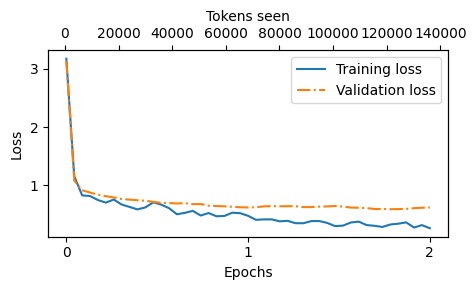

In [30]:
from load_weights import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [31]:
torch.manual_seed(123)


for entry in test_data[:5]:

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

--------- Instruction ----------------------------------------
Rewrite the sentence using a simile. 
--------------------------------------------------------------

Input: The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a cheetah.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

--------- Instruction ----------------------------------------
What type of cloud is typically associated with thunderstorms? 
--------------------------------------------------------------

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> A thunderstorm is a type of cloud that typically forms when thunderstorms are active.
-------------------------------------
Below is an ins

From here need to process

In [32]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

    test_data[i]["model_response"] = response_text


with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)  # "indent" for pretty-printing

100%|██████████| 110/110 [01:10<00:00,  1.57it/s]


In [33]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': 'The car is as fast as a cheetah.'}


In [34]:
import re


file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

# Load model via
# model.load_state_dict(torch.load("gpt2-medium355M-sft.pth"))

Model saved as gpt2-medium355M-sft.pth


Evaluating the model

In [35]:
import psutil

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError("Ollama not running. Launch ollama before proceeding.")
print("Ollama running:", check_if_running("ollama"))

RuntimeError: Ollama not running. Launch ollama before proceeding.